In [2]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain.agents import create_agent
from langchain_ollama import ChatOllama
from typing import TypedDict

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
import os
import requests
from dotenv import load_dotenv

load_dotenv()

memory = MemorySaver()

In [3]:
# tools
# Tool - 1: DuckDuckGo Search


@tool(description="This tool is useful for searching the web for recent information. also you can get the current weather details for the specific location")
def web_search_tool(query: str) -> str:
    search = DuckDuckGoSearchRun()

    response = search.invoke(query)

    return response


# tool - 2: Wikipedia Search

@tool(description="This tool is useful for searching Wikipedia for specific information.")
def wiki_tool(query: str) -> str:
    wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

    response = wiki_tool.invoke(query)

    return response

# tool - 3: calculator tool


@tool(description="A simple calculator to perform basic arithmetic operations.")
def calculator_tool(expression: str) -> str:
    try:
        # Evaluate the arithmetic expression
        result = eval(expression)
        return str(result)
    except Exception as e:
        return f"Error evaluating expression: {e}"

# tool - 4: weather tool
# get current weather tool


@tool
def get_current_weather(location: str) -> str:
    """useful to get the current weather for a given location"""

    base_url = " http://api.weatherapi.com/v1"
    api_key = os.getenv("WEATHER_API_KEY")
    endpoint = f"/current.json?key={api_key}&q={location}&aqi=no"
    url = base_url + endpoint

    response = requests.get(url)
    weather_data = response.json()
    current_temp = weather_data["current"]["temp_c"]
    condition = weather_data["current"]["condition"]["text"]
    return f"The current temperature in {location} is {current_temp}°C with {condition}."

# tool 5 - currency conversion tool


@tool
def Usd_to_Inr(amount: float) -> str:
    "Useful to Convert USD to INR"

    base_url = "https://api.currencyapi.com/v3/latest?apikey=cur_live_QMylKjBXtXovDcBt8dfipB8QHhzvnrrGfzhdf3Xk&currencies=INR"

    response = requests.get(base_url)
    data = response.json()
    rate = data["data"]["INR"]["value"]
    inr_amount = amount * rate
    return f"{amount} USD is equal to {inr_amount} INR."

In [ ]:
tools = [web_search_tool, wiki_tool,
         calculator_tool, get_current_weather, Usd_to_Inr]

In [5]:
class AgentState(TypedDict):
    user_input: str
    agent1_output: str
    final_output: str

In [6]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud")

agent1 = create_agent(
    model=llm,
    system_prompt="you are a helpful assistant.",
    tools=tools,
    checkpointer=memory
)

agent2 = create_agent(
    model=llm,
    system_prompt="you are a language translation assistant. Translate text into Hindi language.",
    tools=tools,
    checkpointer=memory
)

In [7]:
def agent1_node(state: AgentState):

    response = agent1.invoke({
        "messages": [{"role": "user", "content": state["user_input"]}]
    })

    return {
        "agent1_output": response["messages"][-1].content
    }

In [8]:
def agent2_node(state: AgentState):

    response = agent2.invoke({
        "messages": [{"role": "user", "content": state["agent1_output"]}]
    })

    return {
        "final_output": response["messages"][-1].content
    }

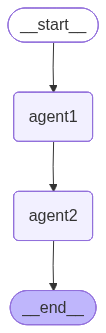

In [9]:
graph = StateGraph(AgentState)

graph.add_node("agent1", agent1_node)
graph.add_node("agent2", agent2_node)

graph.add_edge(START, "agent1")
graph.add_edge("agent1", "agent2")
graph.add_edge("agent2", END)

app = graph.compile(checkpointer=memory)
app

In [ ]:
config = {"configurable": {"thread_id": "1"}}

while True:
    user_inp = input("Enter your message: ")
    if user_inp.lower() == "exit":
        break
    
    result = app.invoke({
        "user_input": user_inp,
        "agent1_output": "",
        "final_output": ""
    }, config=config)

    # print(result["final_output"])
    print()
    print(result["agent1_output"])


Hello Yash! Nice to meet you! 😊 

How can I help you today? I can assist with various things - from answering questions and doing calculations to searching for information online or checking the weather. Just let me know what you need!

453 - 23 = 430

I'm afraid I cannot tell you what your name is, as I don't have access to that personal information. My capabilities are focused on helping with tasks like searching for information, calculations, weather updates, and currency conversions.

If you'd like, I can help you with any of those types of questions instead!
